# Project: Investigate alcohol consumption
## Table of contents
 - <a href="#intro">Introduction</a>
 - <a href="#wrangle">Data wrangling and cleaning</a>
 - <a href="#explore">Exploratory analysis</a>
 - <a href="#discussion">Discussion</a>

<a id="intro"></a>
## Introduction

For my analysis project, I choose the "Gapminder World" dataset. After examining the available variables, I choose *"Alcohol consumption per adult"* indicator as the dependent variable and the following three as the independent variable: 

 - *"Prevalence of current tobacco use among adults (>=15 years) (%, both sexes)"*
 - *"Income per person (fixed 2000 US\$)"*
 - *"Total 15+ unemployed (%)"*

After an initial examination, I found that the matrix of measurements are extremely sparse, but in 2005 many countries have a value, so I decided to take only this year into account.

Using these variables, I decided to research this three questions:

 1. "How does the economy of a country relate to alcohol consumption?"
 2. "Is there any connection between addiction to alcohol and tobacco?"
 3. "Where is Hungary - my home country - on these lists and what can we say about it compared to other countries?"

In [1]:
# Importing necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Magic word for plots
%matplotlib inline

# Define basic variables
DATA_DIR = 'ds'
FILE_NAMES = ['alcohol', 'smoking', 'income', 'unemployment']

In [5]:
# Utility function definitions


<a id="wrangle"></a>
## Data wrangling and cleaning

### Loading data
As a first step, I read in the datasets with pandas into dataframe and put them in a single list. I used the name of the country as index and the name of the file as column name.

In [2]:
df_list = []
for fname in FILE_NAMES :
    full_path = DATA_DIR + '/' + fname + '.csv'
    df = pd.read_csv(full_path, index_col=0, header=0, sep=',')
    df_list.append(df)

After that, I joined the dataframes by the name of the country.

In [6]:
df = pd.concat(df_list, axis=1)

### Cleaning
I wanted to use the same dataset for all of my three questions. But, different countries had different missing values. To preserve the consistency, I decided to retain only those countries for which I had a value for all four indicators.

As a third (bonus) question I want to inspect Hungary, so I save it for later use (because the unemployment ratio is missing).

In [9]:
print('Total number of countries: {}'.format(len(df)))
df_hun = df.loc['Hungary']
df = df[~(df.isnull().any(axis=1))]
print('Number of countries after missing value removal: {}'.format(len(df)))

Total number of countries: 295
Number of countries after missing value removal: 24


I was curious about which countries remained, so I printed out them:

In [10]:
print(', '.join(list(df.index)))

Australia, Canada, Estonia, Finland, France, Germany, Ireland, Japan, Latvia, Lithuania, Netherlands, New Zealand, Norway, Philippines, Poland, Portugal, Romania, Slovenia, Spain, Sweden, Switzerland, Turkey, United Kingdom, United States


### Handling possible outliers

I know that all country in my dataset has all four measurement. But is there any outlier which we need to handle?
I drew a histogram for each variable and looked at them.

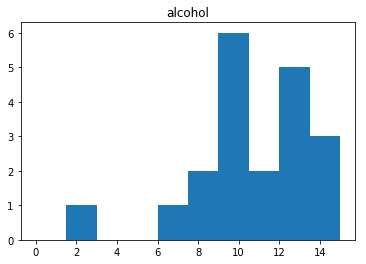

In [11]:
hist1 = df.loc[:, FILE_NAMES[0]].hist(grid=False, bins=10, range=(0,15))
hist1 = plt.title(FILE_NAMES[0])

On this histogram I can see one outlier where the yearly consumption fall far from the other values. I selected this country by value:

In [12]:
outlier_country = list(df.loc[df.loc[:,'alcohol'] < 5].index)
print('Outlier country based on alcohol consumption: ' + ', '.join(outlier_country))

Outlier country based on alcohol consumption: Turkey


I examined the three independent variable too the same way.

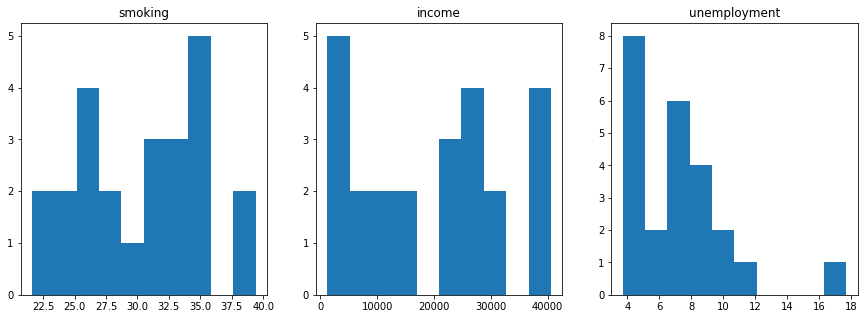

In [84]:
histogram_list = [[] for i in range(0, 3)]
plt.figure(figsize=(15,5))
for i in range(1, 4) :
    plt.subplot(1, 3, i)
    histogram_list[i-1] = df.loc[:, FILE_NAMES[i]].hist(grid=False)
    plt.title(FILE_NAMES[i])

In [91]:
smoking_outlier = list(df.loc[df.loc[:, 'smoking']>35].index)
print('Outlier countries based on smoking: ' + ', '.join(smoking_outlier))

Outlier countries based on smoking: Estonia, Latvia, Poland, Portugal, Turkey, United Kingdom


In [92]:
unemp_outlier = list(df.loc[df.loc[:, 'unemployment']>15].index)
print('Outlier countries based on unemployment ratio: ' + ', '.join(unemp_outlier))

Outlier countries based on unemployment ratio: Poland


Looking at the histogram, I didn't consider any country as outlier based on income. I think these outlier values don't seem to be invalid or erroneous I decided to retain them in my analysis.

### General properties of dataset

After the initial cleaning step I performed some basic descriptive statistic measurement.

In [14]:
import scipy.stats as sts

In [24]:
for field in ['smoking', 'income', 'unemployment'] :
    (stat,pval) = sts.normaltest(df.loc[:, field].values)
    
    if pval < 0.05 :
        decision = 'rejected'
    else :
        decision = 'accepted'
        
    print('Normality of variable \'' + field + '\' is {} at 0.05 significance level.'.format(decision))

Normality of variable 'smoking' is accepted at 0.05 significance level.
Normality of variable 'income' is accepted at 0.05 significance level.
Normality of variable 'unemployment' is rejected at 0.05 significance level.


In [104]:
df.mean()

alcohol            11.455417
smoking            30.558333
income          19787.642021
unemployment        7.354167
dtype: float64

In [106]:
df.std()

alcohol             3.185336
smoking             5.117652
income          12783.649880
unemployment        3.056281
dtype: float64

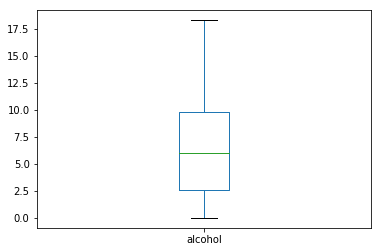

In [38]:
#df.loc[:, 'alcohol'].hist(range=(0,20), bins=40, grid=False)
df.boxplot('alcohol', grid=False)

In [48]:
quantiles = df.loc[:, 'alcohol'].quantile([0, 0.25, 0.5, 0.75, 1])

In [49]:
print(quantiles)

0.00     0.0200
0.25     2.5825
0.50     5.9900
0.75     9.7775
1.00    18.2800
Name: alcohol, dtype: float64


In [51]:
group_by_alcohol = {}
for i in range(1, 5) :
    group_by_alcohol[i] = df[quantiles[i-1]<=df.loc[:,'alcohol'] and df.loc[:,'alcohol']<quantiles[i]]

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

<a id="explore"></a>
## Exploratory analysis

### Question one: How does the economy of a country relate to alcohol consumption?

### Question two: Is there any connection between addiction to alcohol and tobacco?

### Question three: Where is Hungary - my home country - on these lists and what can we say about it compared to other countries?

<a id="discussion"></a>
## Discussion